# RAMOSE log analysis


In [2]:
import pandas as pd
import zipfile , csv , re

Load data from zip file to a dataframe

In [53]:
zf1 = zipfile.ZipFile('log-2018-0212-filtered.csv.zip')
df1 = pd.read_csv(zf1.open('log-2018-0212-filtered.csv'), sep=',', error_bad_lines=False, quoting=csv.QUOTE_NONE, warn_bad_lines=False)

zf2 = zipfile.ZipFile('log-2019-0112-filtered.csv.zip')
df2 = pd.read_csv(zf2.open('log-2019-0112-filtered.csv'), sep=',', error_bad_lines=False, quoting=csv.QUOTE_NONE, warn_bad_lines=False)

zf3 = zipfile.ZipFile('log-2020-0102-filtered.csv.zip')
df3 = pd.read_csv(zf3.open('log-2020-0102-filtered.csv'), sep=',', error_bad_lines=False, quoting=csv.QUOTE_NONE, warn_bad_lines=False)

zf4 = zipfile.ZipFile('log-2020-0105-filtered.csv.zip')
df4 = pd.read_csv(zf4.open('log-2020-0105-filtered.csv'), sep=',', error_bad_lines=False, quoting=csv.QUOTE_NONE, warn_bad_lines=False)
df = pd.concat([df1, df2, df3, df4]) #, ignore_index=True
df.head()

,TIME,REMOTE_ADDR,HTTP_USER_AGENT,HTTP_REFERER,HTTP_HOST,REQUEST_URI
"""2018-02-22 23:26:13","453""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,None,130.136.130.1,/
"""2018-02-22 23:26:20","244""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://130.136.130.1/,130.136.130.1,/about
"""2018-02-22 23:26:21","689""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://130.136.130.1/about,130.136.130.1,/corpus
"""2018-02-22 23:26:24","245""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://130.136.130.1/corpus,130.136.130.1,/model
"""2018-02-22 23:38:49","424""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,None,130.136.130.1,/corpus/br/1.html


In [54]:
print(len(df))

41106724


## Pruning and cleansing

Prune all sparql queries that start from a search text

In [55]:
df_sparql = df[(df['REQUEST_URI'].str.match('^/sparql\?query.*')== True) & (df["HTTP_REFERER"].str.contains('search.*')==False)]

In [56]:
print(len(df_sparql))
df_sparql.head(20)

1652299


,TIME,REMOTE_ADDR,HTTP_USER_AGENT,HTTP_REFERER,HTTP_HOST,REQUEST_URI
"""2018-02-23 20:03:10","904""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,None,130.136.130.1,/sparql?query=select%20distinct%20?scheme%20{%...
"""2018-02-24 09:28:46","379""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...
"""2018-02-24 09:30:13","025""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...
"""2018-02-24 09:34:03","132""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...
"""2018-02-24 17:39:06","074""",85.0.40.84,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:58....,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...
"""2018-02-25 10:23:16","169""",46.135.89.242,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:58....,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...
"""2018-02-26 05:41:11","550""",138.100.15.135,Mozilla/4.0 (compatible; Virtuoso),None,opencitations.net,/sparql?query=%20SELECT%20%3Ftitle%20%3Fcited_...
"""2018-02-26 05:41:11","606""",138.100.15.135,Mozilla/4.0 (compatible; Virtuoso),None,opencitations.net,/sparql?query=%20SELECT%20%3Ftitle%20%3Fcited_...
"""2018-02-26 05:41:11","659""",138.100.15.135,Mozilla/4.0 (compatible; Virtuoso),None,opencitations.net,/sparql?query=%20SELECT%20%3Ftitle%20%3Fcited_...
"""2018-02-26 05:41:11","714""",138.100.15.135,Mozilla/4.0 (compatible; Virtuoso),None,opencitations.net,/sparql?query=%20SELECT%20%3Ftitle%20%3Fcited_...


### Distribution of queries

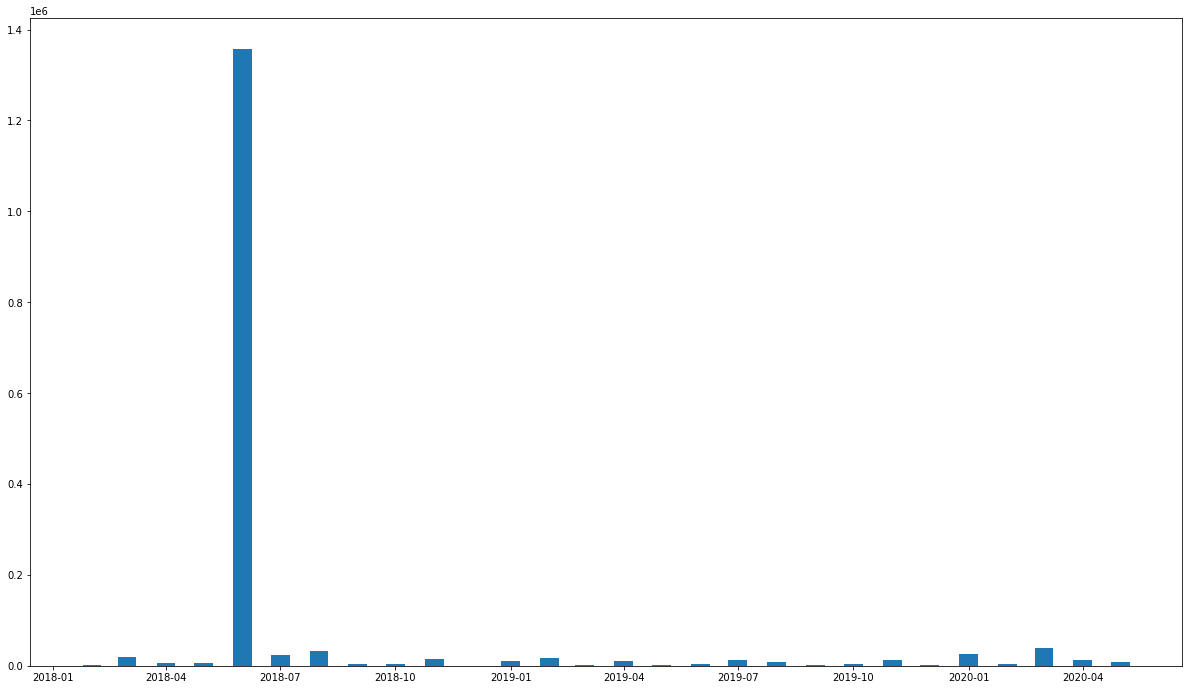

In [85]:
#df_sparql_plot = df_sparql.groupby("TIME")['REQUEST_URI'].apply(lambda tags: len(tags))
#df_sparql_plot.head()
import matplotlib.pyplot as plt

df_sparql['T'] = df_sparql.index
df_sparql['T'] = df_sparql['T'].apply(lambda x: x[1:8])

dates , queries = [], []
for key,group_df in df_sparql.groupby('T'):
    dates.append(pd.to_datetime(key, format = '%Y-%m'))
    queries.append(len(group_df))

fig = plt.figure(figsize=(16,9))
ax = fig.add_axes([0,0,1,1])
ax.set_yscale('linear')
ax.bar(dates,queries, width = 15)
plt.show()

Clean the queries (add a new column to the dataframe) and label those that have less than 4 query variables.

In [74]:
from urllib.parse import unquote
def clean_query(query):
    # unescape query
    q = unquote(query).replace('+',' ')
    # remove prefixes
    q1 = re.sub('\/sparql\?query', '', q, flags=re.IGNORECASE | re.S | re.DOTALL) # does not work
    q2 = re.sub('(prefix.*<.*?>).*select', '', q1, flags=re.IGNORECASE | re.S | re.DOTALL) 
    q2_1 = re.sub('(\&format\=json)|(output\=json)|(results\=json)','',q2, flags=re.IGNORECASE) # &output=json&results=json
    # normalise variables
    q3 = re.sub('(\?\w+)', '?v', q2_1)
    # normalise URIs
    q4 = re.sub('(<.*>)','<uri>', q3)
    # normalise strings
    q5 = re.sub('(\".*\")','"string"',q4)
    q6 = re.sub('(\'.*\')','"string"',q5)
    q7 = re.sub('\n','',q6)
    q8 = re.sub('\s+','',q7)
    q9 = re.sub('(limit\d+)','',q8, flags=re.IGNORECASE)
    q10 = re.sub('(offset\d+)','',q9, flags=re.IGNORECASE)
    return q10

def match_tail_queries(query):
    # match queries with less than 4 query variables
    variables = query.split("{", 1)[0]
    return 'tail query' if variables.count('?') < 4 else query

In [75]:
df_sparql['CLEAN_QUERY'] = df_sparql['REQUEST_URI']
df_sparql['CLEAN_QUERY'] = df_sparql['CLEAN_QUERY'].apply(clean_query)
df_sparql['CLEAN_QUERY'] = df_sparql['CLEAN_QUERY'].apply(match_tail_queries)
df_sparql.head()
# print(df_sparql.iloc[1,5])

<ipython-input-75-081b1f131f9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sparql['CLEAN_QUERY'] = df_sparql['REQUEST_URI']
<ipython-input-75-081b1f131f9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sparql['CLEAN_QUERY'] = df_sparql['CLEAN_QUERY'].apply(clean_query)
<ipython-input-75-081b1f131f9a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

,TIME,REMOTE_ADDR,HTTP_USER_AGENT,HTTP_REFERER,HTTP_HOST,REQUEST_URI,T,CLEAN_QUERY
"""2018-02-23 20:03:10","904""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,None,130.136.130.1,/sparql?query=select%20distinct%20?scheme%20{%...,2018-02,tail query
"""2018-02-24 09:28:46","379""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,2018-02,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
"""2018-02-24 09:30:13","025""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,2018-02,tail query
"""2018-02-24 09:34:03","132""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,2018-02,tail query
"""2018-02-24 17:39:06","074""",85.0.40.84,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:58....,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,2018-02,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...


In [76]:
print(len(df_sparql))

1652299


Prune queries that have less than 4 query variables.

In [77]:
# prune queries that have < 4 query variables
df_sparql_no_tail = df_sparql[df_sparql['CLEAN_QUERY'].str.match('tail query')== False]
df_sparql_no_tail.head(10)

,TIME,REMOTE_ADDR,HTTP_USER_AGENT,HTTP_REFERER,HTTP_HOST,REQUEST_URI,T,CLEAN_QUERY
"""2018-02-24 09:28:46","379""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,2018-02,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
"""2018-02-24 17:39:06","074""",85.0.40.84,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:58....,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,2018-02,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
"""2018-02-25 10:23:16","169""",46.135.89.242,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:58....,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,2018-02,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
"""2018-02-26 15:46:44","276""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,2018-02,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
"""2018-02-26 15:46:57","158""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,2018-02,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
"""2018-02-26 15:47:33","041""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,2018-02,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
"""2018-02-26 15:47:44","882""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,2018-02,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
"""2018-02-26 15:48:31","721""",82.217.102.220,Mozilla/5.0 (Android 7.1.2; Mobile; rv:58.0) G...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,2018-02,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
"""2018-02-26 15:51:55","501""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,2018-02,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
"""2018-02-26 15:56:09","132""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,2018-02,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...


In [78]:
print(len(df_sparql_no_tail))

60040


Prune queries that have been performed less than 10 times.

In [79]:
queries = df_sparql_no_tail['CLEAN_QUERY'].tolist()
from collections import Counter
counter_queries = Counter(queries).most_common()

# queries > 10 times
queries_10_min = {q:c for q,c in counter_queries if c >= 10}
size_queries = 0
types_queries = len(queries_10_min)
for q,c in queries_10_min.items():
    size_queries += c
    
# queries < 10 times
queries_outliers = {q:c for q,c in counter_queries if c < 10}
size_outliers = 0
types_outliers = len(queries_outliers)
for q,c in queries_outliers.items():
    size_outliers += c

print(types_queries, 'queries performed more than 10 times (',size_queries,'total queries)' )    
print(types_outliers, 'queries performed less than 10 times (',size_outliers, 'total times)')

72 queries performed more than 10 times ( 59647 total queries)
162 queries performed less than 10 times ( 393 total times)


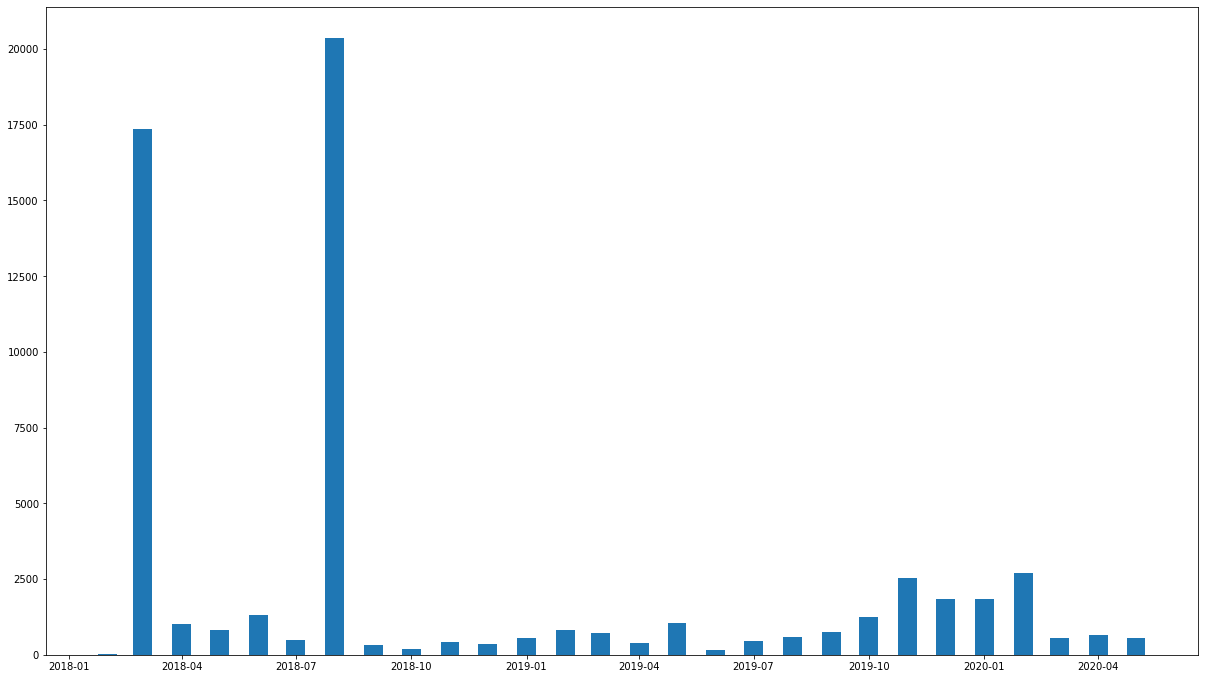

In [87]:
dates , queries = [], []
for key,group_df in df_sparql_no_tail.groupby('T'):
    dates.append(pd.to_datetime(key, format = '%Y-%m'))
    queries.append(len(group_df))

fig = plt.figure(figsize=(16,9))
ax = fig.add_axes([0,0,1,1])
ax.bar(dates,queries, width = 15)
plt.show()

## Match with API calls
Here below the 5 SPARQL queries performed by OC APIs

In [88]:
metadata = """PREFIX cito: <http://purl.org/spar/cito/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX fabio: <http://purl.org/spar/fabio/>
PREFIX frbr: <http://purl.org/vocab/frbr/core#>
PREFIX datacite: <http://purl.org/spar/datacite/>
PREFIX literal: <http://www.essepuntato.it/2010/06/literalreification/>
PREFIX pro: <http://purl.org/spar/pro/>
PREFIX oco: <https://w3id.org/oc/ontology/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX prism: <http://prismstandard.org/namespaces/basic/2.0/>

SELECT DISTINCT ?occ_id ?author ?year ?title ?source_title ?volume ?issue ?page ?doi ?occ_reference ?doi_reference ?citation_count
WHERE {
    VALUES ?doi { "string" } 
    ?article a fabio:Expression ; 
        datacite:hasIdentifier [datacite:usesIdentifierScheme datacite:doi ; literal:hasLiteralValue ?doi] .
    BIND (STRAFTER(str(?article), "https://w3id.org/oc/corpus/") as ?occ_id)
    { SELECT DISTINCT ?article (GROUP_CONCAT(?cited_occ_id; separator="; ") as ?occ_reference) (GROUP_CONCAT(?cited_doi; separator="; ") as ?doi_reference) 
    {
      VALUES ?doi { [["string"]] } 
      ?article a fabio:Expression ;
          datacite:hasIdentifier [ datacite:usesIdentifierScheme datacite:doi ; literal:hasLiteralValue ?doi ] .
        OPTIONAL {
            ?article cito:cites ?cited .
            BIND(STRAFTER(str(?cited), "https://w3id.org/oc/corpus/") as ?cited_occ_id)
            OPTIONAL {
                ?cited datacite:hasIdentifier [
                    datacite:usesIdentifierScheme datacite:doi ;
                    literal:hasLiteralValue ?cited_doi
                ] .
                FILTER(!STRSTARTS(?cited_doi, "http") && !STRENDS(?cited_doi, ".") && !STRENDS(?cited_doi, "("))
                }
            }
        } GROUP BY ?article
    }
    {
        SELECT ?article ?doi (count(?doi) as ?citation_count) {
			VALUES ?doi { [[dois]] }

			?article a fabio:Expression ;
                datacite:hasIdentifier [
                    datacite:usesIdentifierScheme datacite:doi ;
                    literal:hasLiteralValue ?doi
                ] .

			OPTIONAL { ?article ^cito:cites ?other }
		} GROUP BY ?article ?doi
	}

	{
		SELECT ?article ?doi (GROUP_CONCAT(?a; separator="; ") as ?author) {
			VALUES ?doi { [[dois]] }

			{
			SELECT ?article ?doi ?a (count(?next) as ?tot) {
				VALUES ?doi { [[dois]] }

				?article a fabio:Expression ;
					datacite:hasIdentifier [
						datacite:usesIdentifierScheme datacite:doi ;
						literal:hasLiteralValue ?doi
					] .

				OPTIONAL {
					?article pro:isDocumentContextFor ?role .
					?role pro:withRole pro:author ; pro:isHeldBy [
						foaf:familyName ?f_name ;
						foaf:givenName ?g_name
					] .
					OPTIONAL { ?role oco:hasNext* ?next }
					BIND(CONCAT(?f_name, ", ",?g_name) as ?a)
				}
			} GROUP BY ?article ?doi ?a ORDER BY DESC(?tot)}
		} GROUP BY ?article ?doi
	}

	OPTIONAL { ?article ^cito:cites ?other }
	OPTIONAL { ?article dcterms:title ?title }
	OPTIONAL { ?article fabio:hasPublicationYear ?year }
	OPTIONAL {
		?article frbr:partOf+ ?source .
		FILTER NOT EXISTS {
			?source frbr:partOf ?another_source
		}
		?source dcterms:title ?source_title
	}
	OPTIONAL {
		?article frbr:partOf+ ?v .
		?v a fabio:JournalVolume ;
			fabio:hasSequenceIdentifier ?volume
	}
	OPTIONAL {
		?article frbr:partOf+ ?i .
		?i a fabio:JournalIssue ;
			fabio:hasSequenceIdentifier ?issue
	}
	OPTIONAL {
		?article frbr:embodiment ?man .
		?man prism:startingPage ?start .
		OPTIONAL { ?man prism:endingPage ?end }
		BIND (CONCAT(?start, IF(bound(?end), CONCAT("-", ?end), "")) as ?page)
	}
}
LIMIT 10000"""

coauthorship = """PREFIX fabio: <http://purl.org/spar/fabio/>
PREFIX datacite: <http://purl.org/spar/datacite/>
PREFIX literal: <http://www.essepuntato.it/2010/06/literalreification/>
PREFIX pro: <http://purl.org/spar/pro/>
PREFIX oco: <https://w3id.org/oc/ontology/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?author1 ?author2 (count(?author1) as ?coauthorship_count) WHERE {
	VALUES ?doi { [[dois]] }

	?article a fabio:Expression ;
		datacite:hasIdentifier [
			datacite:usesIdentifierScheme datacite:doi ;
			literal:hasLiteralValue ?doi
		] ;

		pro:isDocumentContextFor ?auth1 , ?auth2 .

		?auth1 oco:hasNext+ ?auth2 .

		?auth1 pro:isHeldBy [
			foaf:givenName ?gn1 ;
			foaf:familyName ?fn1
		] .
		?auth2 pro:isHeldBy [
			foaf:givenName ?gn2 ;
			foaf:familyName ?fn2
		] .

	BIND (CONCAT(?fn1, ", ", ?gn1) as ?author1) .
	BIND (CONCAT(?fn2, ", ", ?gn2) as ?author2) .
}
GROUP BY ?author1 ?author2
LIMIT 10000"""

references = """PREFIX cito: <http://purl.org/spar/cito/>
SELECT ?oci ?citing ?cited ?creation ?timespan (IF(bound(?jsc), "yes", "no") as ?journal_sc) (IF(bound(?asc), "yes", "no") as ?author_sc)
WHERE {
    GRAPH <https://w3id.org/oc/index/coci/> {
        BIND(<http://dx.doi.org/[[doi]]> as ?citing_iri) .
        ?citing_iri ^cito:hasCitingEntity ?oci_iri .
        ?oci_iri
            cito:hasCitedEntity ?cited_iri ;
            cito:hasCitationCreationDate ?creation ;
            cito:hasCitationTimeSpan ?timespan .

        OPTIONAL {
            ?oci_iri a cito:JournalSelfCitation .
            BIND("yes" as ?jsc)
        }

        OPTIONAL {
            ?oci_iri a cito:AuthorSelfCitation .
            BIND("yes" as ?asc)
        }

        BIND(STRAFTER(str(?citing_iri), "http://dx.doi.org/") AS ?citing)
        BIND(STRAFTER(str(?cited_iri), "http://dx.doi.org/") AS ?cited)
        BIND(STRAFTER(str(?oci_iri), "/ci/") AS ?oci)
    }
}
LIMIT 10000"""

citations = """PREFIX cito: <http://purl.org/spar/cito/>
SELECT ?oci ?citing ?cited ?creation ?timespan (IF(bound(?jsc), "yes", "no") as ?journal_sc) (IF(bound(?asc), "yes", "no") as ?author_sc)
WHERE {
    GRAPH <https://w3id.org/oc/index/coci/> {
        BIND(<http://dx.doi.org/[[doi]]> as ?cited_iri) .
        ?cited_iri ^cito:hasCitedEntity ?oci_iri .
        ?oci_iri
            cito:hasCitingEntity ?citing_iri ;
            cito:hasCitationCreationDate ?creation ;
            cito:hasCitationTimeSpan ?timespan .

        OPTIONAL {
            ?oci_iri a cito:JournalSelfCitation .
            BIND("yes" as ?jsc)
        }

        OPTIONAL {
            ?oci_iri a cito:AuthorSelfCitation .
            BIND("yes" as ?asc)
        }

        BIND(STRAFTER(str(?citing_iri), "http://dx.doi.org/") AS ?citing)
        BIND(STRAFTER(str(?cited_iri), "http://dx.doi.org/") AS ?cited)
        BIND(STRAFTER(str(?oci_iri), "/ci/") AS ?oci)
    }
}
LIMIT 10000"""

citation = """
PREFIX cito: <http://purl.org/spar/cito/>
SELECT ?oci ?citing ?cited ?creation ?timespan (IF(bound(?jsc), "yes", "no") as ?journal_sc) (IF(bound(?asc), "yes", "no") as ?author_sc)
WHERE {
    GRAPH <https://w3id.org/oc/index/coci/> {
        BIND(<https://w3id.org/oc/index/coci/ci/[[oci]]> as ?oci_iri) .
        ?oci_iri
            cito:hasCitingEntity ?citing_iri ;
            cito:hasCitedEntity ?cited_iri ;
            cito:hasCitationCreationDate ?creation ;
            cito:hasCitationTimeSpan ?timespan .

        OPTIONAL {
            ?oci_iri a cito:JournalSelfCitation .
            BIND("yes" as ?jsc)
        }

        OPTIONAL {
            ?oci_iri a cito:AuthorSelfCitation .
            BIND("yes" as ?asc)
        }

        BIND(STRAFTER(str(?citing_iri), "http://dx.doi.org/") AS ?citing)
        BIND(STRAFTER(str(?cited_iri), "http://dx.doi.org/") AS ?cited)
        BIND(STRAFTER(str(?oci_iri), "/ci/") AS ?oci)
    }
}
LIMIT 10000"""

metadata_clean = clean_query(metadata)
references_clean = clean_query(references)
citations_clean = clean_query(citations)
citation_clean = clean_query(citation)
coauthorship_clean = clean_query(coauthorship)
api_calls = [metadata_clean, references_clean, citations_clean, citation_clean, coauthorship_clean]
api_names = ['metadata_clean', 'references_clean', 'citations_clean', 'citation_clean', 'coauthorship_clean']

Cluster SPARQL queries by affinity propagation.

In [89]:
import distance
import numpy as np
from sklearn.cluster import AffinityPropagation
queries_10_min_list = [q for q,c in queries_10_min.items()]
queries_10_min_list = np.asarray(queries_10_min_list)
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in queries_10_min_list] for w2 in queries_10_min_list])

# affinity propagation for clustering 
# Reference: Brendan J. Frey and Delbert Dueck, “Clustering by Passing Messages Between Data Points”, Science Feb. 2007
affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = queries_10_min_list[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(queries_10_min_list[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = "\n ".join(cluster)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


## Plotting clusters

Processed 10/72 rows of api call
Processed 20/72 rows of api call
Processed 30/72 rows of api call
Processed 40/72 rows of api call
Processed 50/72 rows of api call
Processed 60/72 rows of api call
Processed 70/72 rows of api call


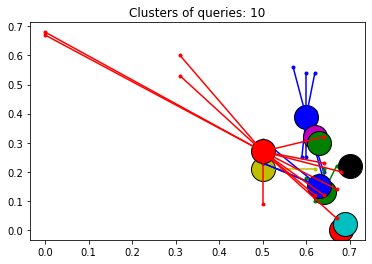

In [92]:
# Plot results
import matplotlib.pyplot as plt
from itertools import cycle
from fuzzywuzzy import fuzz

plt.close('all')
plt.figure(1)
plt.clf()

def compute_similarity(s1, s2):
    return 1.0 - (0.01 * max(
        fuzz.ratio(s1, s2),
        fuzz.partial_ratio(s1, s2),
        fuzz.token_set_ratio(s1, s2)))

X = np.zeros((len(queries_10_min_list), len(queries_10_min_list)))
for i in range(len(queries_10_min_list)):
    if i > 0 and i % 10 == 0:
        print("Processed %d/%d rows of sparql queries" % (i, X.shape[0]))
    for j in range(len(queries_10_min_list)):
        if X[i, j] == 0.0:        
            X[i, j] = compute_similarity(queries_10_min_list[i].lower(), queries_10_min_list[j].lower())
            X[j, i] = X[i, j]

n_clusters_ = len(affprop.cluster_centers_indices_)
cluster_centers_indices = affprop.cluster_centers_indices_
labels = affprop.labels_

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=24)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Clusters of queries: %d' % n_clusters_)
plt.show()

## Match to API calls

Exemplars in clusters are matched against SPARQL queries performed by the APIs. The similarity is calculated by using  Levenshtein Distance between the query strings, specifically by analysing the sets of tokens that appear in both the queries.

overview:


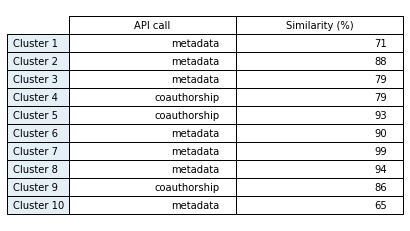

In [102]:
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

print("overview:" )
i = 0
cell_text , row_headers = [] , []
for cluster_id in np.unique(affprop.labels_):
    exemplar = queries_10_min_list[affprop.cluster_centers_indices_[cluster_id]]
    original_q = unquote(df_sparql_no_tail.loc[df_sparql_no_tail['CLEAN_QUERY'] == exemplar, 'REQUEST_URI'].iloc[0]).replace('+',' ')
    i+=1
    best_match = process.extractOne(exemplar,api_calls, scorer=fuzz.token_set_ratio)
    #best_match = process.extractOne(exemplar,api_calls, score_cutoff=80)
    index = api_calls.index(best_match[0])
    name = api_names[index].replace('_clean','')  
    row_headers.append('Cluster '+str(i))
    cell_text.append([name, best_match[1]])
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
column_headers = ['API call', 'Similarity (%)'] 
the_table = plt.table(cellText=cell_text,
                  rowLabels=row_headers,
                  rowColours=rcolors,
                  colLabels=column_headers,
                  loc='center')

the_table.scale(1, 1.5)


